## Some code blocks are repeated with minor changes just for convenience of access to results

In [1]:
import pandas as pd
import csv
import nibabel as nib
import copy
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import scipy.ndimage.measurements as measurements
from collections import namedtuple
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import KFold

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



## Get survival_info.csv dataframe

In [2]:
base_dir = '../reg_dataset/'
df_survival = pd.read_csv(base_dir + 'survival_info.csv', usecols=['Brats20ID','Survival_days'])
print(df_survival)
li=df_survival['Survival_days'].to_list()
print(len(li),li)
survival_info = dict(zip(df_survival.Brats20ID, df_survival.Survival_days))

                Brats20ID  Survival_days
0    BraTS20_Training_001            289
1    BraTS20_Training_002            616
2    BraTS20_Training_003            464
3    BraTS20_Training_004            788
4    BraTS20_Training_005            465
..                    ...            ...
231  BraTS20_Training_363             62
232  BraTS20_Training_366            633
233  BraTS20_Training_367            437
234  BraTS20_Training_368            442
235  BraTS20_Training_369            145

[236 rows x 2 columns]
236 [289, 616, 464, 788, 465, 269, 503, 1278, 1155, 515, 421, 495, 698, 359, 169, 368, 439, 486, 287, 55, 576, 350, 332, 331, 23, 203, 336, 106, 32, 466, 170, 488, 473, 1283, 33, 89, 172, 30, 84, 229, 286, 726, 495, 871, 210, 318, 208, 660, 522, 407, 265, 85, 597, 239, 610, 208, 355, 152, 385, 453, 1592, 376, 1337, 12, 579, 614, 387, 180, 139, 375, 1767, 168, 438, 345, 394, 114, 191, 50, 387, 58, 734, 448, 401, 361, 996, 510, 1020, 436, 296, 278, 146, 200, 1527, 1178, 353, 56, 21

### Plot histogram and box polt with survival days

Mean survival Days:445.45338983050846 Days
Std dev: 354.4047915901651 Days
Mean Absolute Error: 258.81521114622234 Days
Mean Square Error: 125602.75630206836 Days squared


{'whiskers': [<matplotlib.lines.Line2D at 0x2511e3d1c18>,
 'caps': [<matplotlib.lines.Line2D at 0x2511e33b390>,
 'boxes': [<matplotlib.lines.Line2D at 0x2511e3d1ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x2511e33ba90>],
 'fliers': [<matplotlib.lines.Line2D at 0x2511e33be10>],
 'means': []}

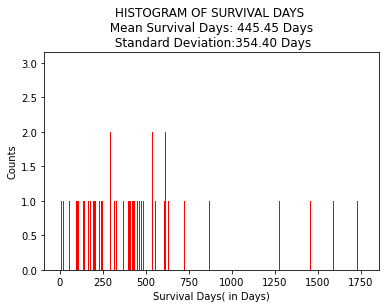

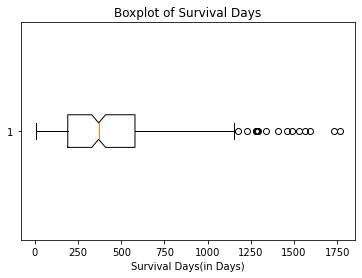

In [22]:

mean_li=np.array(li).mean()

bins = np.arange(0, np.amax(li) + 1.5) - 0.5
plt.title(f'HISTOGRAM OF SURVIVAL DAYS \n Mean Survival Days: {mean_li:.2f} Days \n Standard Deviation:{np.array(li).std():.2f} Days')
plt.hist(li, density=False,bins=bins, color='r') 

print(f'Mean survival Days:{mean_li} Days')
print(f'Std dev: {np.array(li).std()} Days')
plt.ylabel('Counts')
plt.xlabel('Survival Days( in Days)')

y_pred = [mean_li,]*len(li)
print(f'Mean Absolute Error: {mean_absolute_error(li, y_pred)} Days')
print(f'Mean Square Error: {mean_squared_error(li,y_pred)} Days squared')


plt.figure()
plt.title('Boxplot of Survival Days')
plt.xlabel('Survival Days(in Days)')
plt.boxplot(li, notch=True, vert=False, patch_artist=None, widths=None,meanline=True)


Segmentation labels have values of
1 for necrotic (NCR) and the non-enhancing (NET) tumor core,
2 for peritumoral edema (ED),
4 for enhancing tumor(ET)

### Fetch curated Seg_widths.csv and plot distributions of each variable

In [3]:
df_seg = pd.read_csv('seg_widths.csv')
print(df_seg)

                Brats20ID  Survival_days     Age  label1  label2  label4
0    BraTS20_Training_001            289  60.463      55     109      61
1    BraTS20_Training_002            616  52.263      33      89      35
2    BraTS20_Training_003            464  54.301      18      63      23
3    BraTS20_Training_004            788  39.068      43      78      42
4    BraTS20_Training_005            465  68.493      51      58      52
..                    ...            ...     ...     ...     ...     ...
231  BraTS20_Training_363             62  57.000      57      84      74
232  BraTS20_Training_366            633  72.000      50      73      65
233  BraTS20_Training_367            437  60.000      43     104      59
234  BraTS20_Training_368            442  49.000      39      75      53
235  BraTS20_Training_369            145  50.000     109     158     126

[236 rows x 6 columns]


Identify distribution of features - age, max width of lesions in each segmentation. 
Plot box plots and histogram to check if guassian or not. This is to standardize the features

Mean Age:61.22320338983051
Std dev: 11.848929809043918


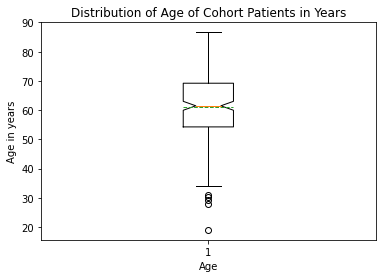

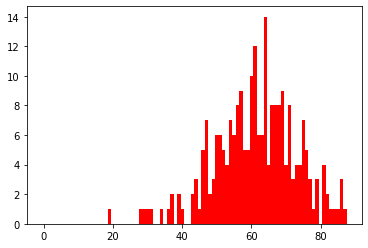

In [4]:
age= np.array(df_seg.Age)
plt.figure()
plt.boxplot(age,notch=True, vert=True, patch_artist=None, widths=None,meanline=True,showmeans=True)
plt.title(
    f'Distribution of Age of Cohort Patients in Years')
plt.xlabel('Age')
plt.ylabel('Age in years')

plt.figure()
bins = np.arange(0, np.amax(age) + 1.5) - 0.5
plt.hist(age, density=False,bins=bins, color='r') 
mean_age=age.mean()

print(f'Mean Age:{mean_age}')
print(f'Std dev: {age.std()}')



Mean label1:47.00423728813559
Std dev: 18.64828294030473


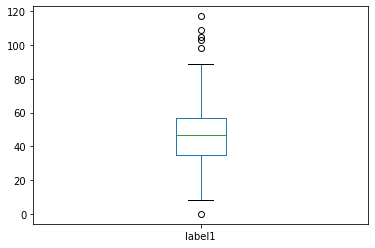

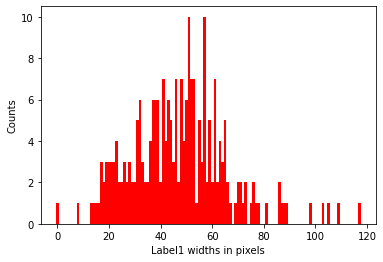

In [5]:
label1 = df_seg.label1
label1.plot(kind = 'box')

plt.figure()
bins = np.arange(0, np.amax(label1) + 1.5) - 0.5
plt.hist(label1, density=False, bins=bins,color='r') 
mean_lable1=np.array(label1).mean()
print(f'Mean label1:{mean_lable1}')
print(f'Std dev: {np.array(label1).std()}')
plt.ylabel('Counts')
plt.xlabel('Label1 widths in pixels');

Mean label2:85.45338983050847
Std dev: 20.474093519816737


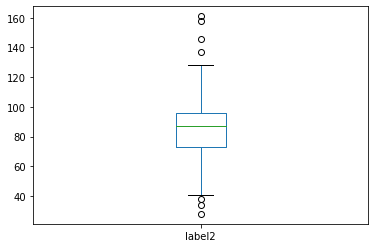

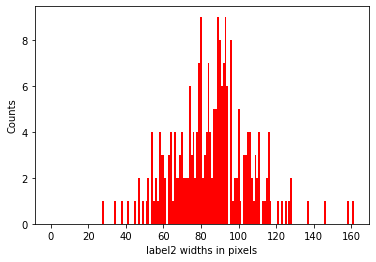

In [6]:
label2 = df_seg.label2
label2.plot(kind = 'box')


plt.figure()
bins = np.arange(0, np.amax(label2) + 1.5) - 0.5
plt.hist(label2, density=False,bins=bins, color='r') 
mean_lable2=np.array(label2).mean()
print(f'Mean label2:{mean_lable2}')
print(f'Std dev: {np.array(label2).std()}')
plt.ylabel('Counts')
plt.xlabel('label2 widths in pixels');

Mean label4:52.25847457627118
Std dev: 18.795197846254826


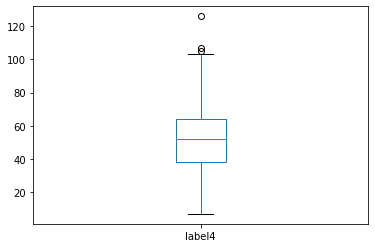

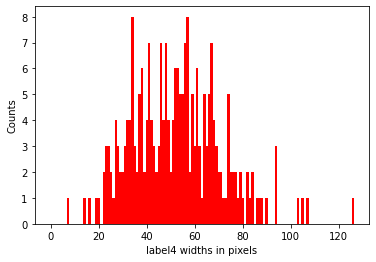

In [7]:
label4 = df_seg.label4
label4.plot(kind = 'box')

plt.figure()
bins = np.arange(0, np.amax(label4) + 1.5) - 0.5
plt.hist(label4, density=False,bins=bins, color='r') 
mean_lable4=np.array(label4).mean()
print(f'Mean label4:{mean_lable4}')
print(f'Std dev: {np.array(label4).std()}')
plt.ylabel('Counts')
plt.xlabel('label4 widths in pixels');

## Correlation maps between variables(max width of each tumor sub-region and age) and target values, Survival days

1.4747915512617297e-08
2.9844436476663156e-05
0.003588459191712083
1.8910878687440376e-06


Text(0, 0.5, 'Survival Days( in days)')

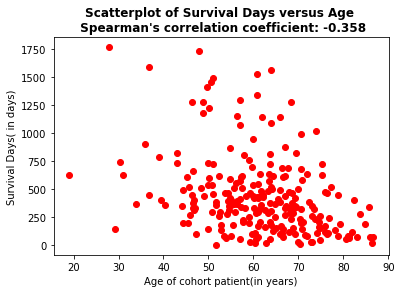

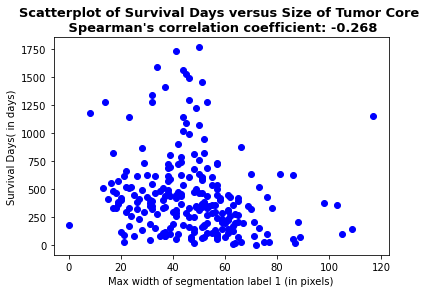

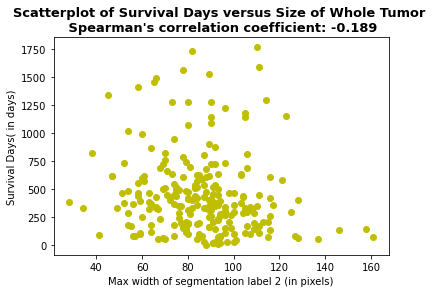

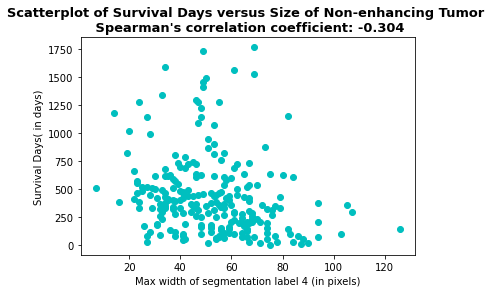

In [8]:

from scipy.stats import spearmanr

plt.figure()
plt.scatter(df_seg.Age,df_seg.Survival_days, color='r')
corr, _ = spearmanr(df_seg.Survival_days, df_seg.Age)
print(_)
plt.title(f'Scatterplot of Survival Days versus Age \n Spearman\'s correlation coefficient: {corr:.3f}',fontweight="bold")
plt.xlabel('Age of cohort patient(in years)')
plt.ylabel('Survival Days( in days)')

plt.figure()
plt.scatter( df_seg.label1,df_seg.Survival_days, color='b')
corr, _ = spearmanr(df_seg.Survival_days, df_seg.label1)
print(_)
plt.title(f'Scatterplot of Survival Days versus Size of Tumor Core \n Spearman\'s correlation coefficient: {corr:.3f}', fontsize=13,fontweight="bold")
plt.xlabel('Max width of segmentation label 1 (in pixels)')
plt.ylabel('Survival Days( in days)')

plt.figure()
plt.scatter(df_seg.label2,df_seg.Survival_days, color='y')
corr, _ = spearmanr(df_seg.Survival_days, df_seg.label2)
print(_)
plt.title(f'Scatterplot of Survival Days versus Size of Whole Tumor \n Spearman\'s correlation coefficient: {corr:.3f}', fontsize=13,fontweight="bold")
plt.xlabel('Max width of segmentation label 2 (in pixels)')
plt.ylabel('Survival Days( in days)')

plt.figure()
plt.scatter(df_seg.label4,df_seg.Survival_days, color='c')
corr, _ = spearmanr(df_seg.Survival_days, df_seg.label4)
print(_)
plt.title(f'Scatterplot of Survival Days versus Size of Non-enhancing Tumor \n Spearman\'s correlation coefficient: {corr:.3f}', fontsize=13,fontweight="bold")
plt.xlabel('Max width of segmentation label 4 (in pixels)')
plt.ylabel('Survival Days( in days)')



## Fitting curve for individual variables with linear kernel SVR(for visualization)

C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

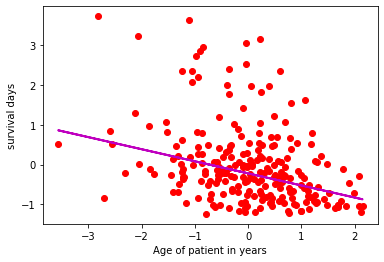

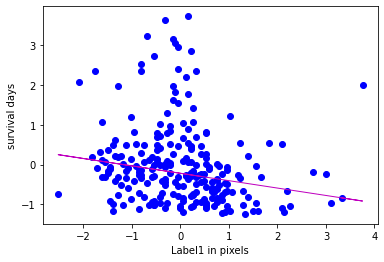

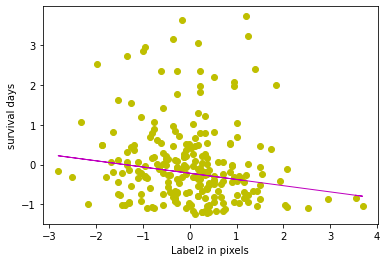

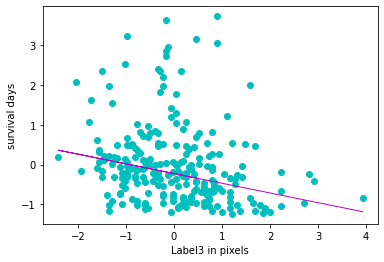

In [9]:
## regression model for individual variables

svr= SVR(kernel='linear', C=100, gamma='auto')
# svr = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)
y=np.array(df_seg.Survival_days).reshape(-1,1)
y=StandardScaler().fit_transform(y)


X=np.array(df_seg.Age).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y, color='r')
plt.xlabel('Age of patient in years')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='m', lw=2,label='rbf model for age')

X=np.array(df_seg.label1).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y, color='b')
plt.xlabel('Label1 in pixels')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='m', lw=1,label='rbf model for label 1 max width')
# mse=mean_squared_error(y_test, ypred)
# r_square= r2_score(y_test, ypred)
# print('mse',mse)
# print('r_sq', r_square)

X=np.array(df_seg.label2).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y,  color='y')
plt.xlabel('Label2 in pixels')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='m', lw=1,label='rbf model for label 2 max width')
# mse=mean_squared_error(y_test, ypred)
# r_square= r2_score(y_test, ypred)
# print('mse',mse)
# print('r_sq', r_square)

X=np.array(df_seg.label4).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y, color='c')
plt.xlabel('Label3 in pixels')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='m', lw=1,label='rbf model for label 4 max width')
# mse=mean_squared_error(y_test, ypred)
# r_square= r2_score(y_test, ypred)
# print('mse',mse)
# print('r_sq', r_square)

## Fitting curve for individual variables with RBF kernel SVR(for visualization)

C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

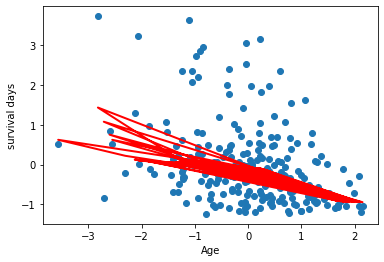

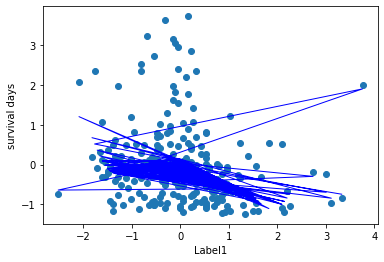

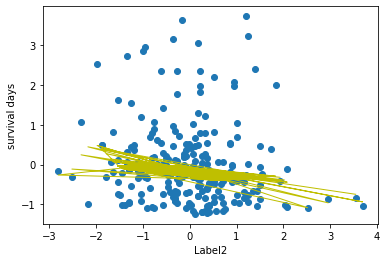

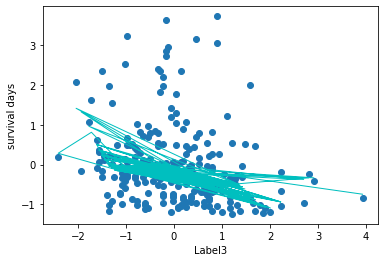

In [10]:
## regression model for scaled variables matrix

svr = SVR(kernel='rbf',C=100)

x_=np.array(df_seg.Age).reshape(-1,1)
y=np.array(df_seg.Survival_days).reshape(-1,1)
X=StandardScaler().fit_transform(x_)
y=StandardScaler().fit_transform(y)
plt.figure()
plt.scatter(X,y)
plt.xlabel('Age')
plt.ylabel('survival days')
y_pred=svr.fit(X, y).predict(X)
plt.plot(X, y_pred, color='r', lw=2,label='rbf model for age')

X=np.array(df_seg.label1).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y)
plt.xlabel('Label1')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='b', lw=1,label='rbf model for label 1 max width')

X=np.array(df_seg.label2).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y)
plt.xlabel('Label2')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='y', lw=1,label='rbf model for label 2 max width')


X=np.array(df_seg.label4).reshape(-1,1)
X=StandardScaler().fit_transform(X)
plt.figure()
plt.scatter(X,y)
plt.xlabel('Label3')
plt.ylabel('survival days')
plt.plot(X, svr.fit(X, y).predict(X), color='c', lw=1,label='rbf model for label 4 max width')


## Boxplot for maximum width of each tumor sub-region

Text(0, 0.5, 'Width (in number of pixels)')

<Figure size 432x288 with 0 Axes>

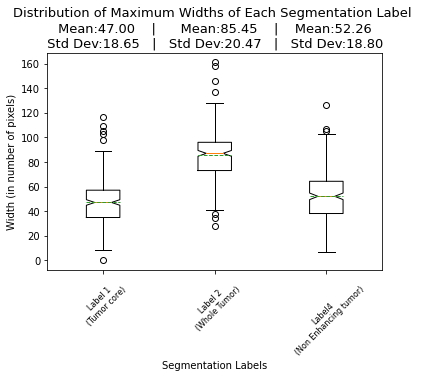

In [12]:
label_val=np.array(df_seg)[:,3:6]
mean_val = np.mean(label_val, axis= 0)
plt.figure()
fig, ax = plt.subplots()
ax.boxplot(label_val,notch=True, vert=True, patch_artist=None, widths=None,meanline=True,showmeans=True)
ax.set_xticklabels(['Label 1\n(Tumor core)', 'Label 2\n(Whole Tumor)', 'Label4\n(Non Enhancing tumor)'], fontsize=8,rotation=45)
ax.set_title(
    f'Distribution of Maximum Widths of Each Segmentation Label \n Mean:{mean_val[0]:.02f}    |      Mean:{mean_val[1]:.02f}    |    Mean:{mean_val[2]:.02f} \n Std Dev:{label_val[:,0].std():.02f}   |   Std Dev:{label_val[:,1].std():.02f}   |   Std Dev:{label_val[:,2].std():.02f} ',fontsize=13)
ax.set_xlabel('Segmentation Labels',fontsize=10)
ax.set_ylabel('Width (in number of pixels)',fontsize=10)

Only the input features X_train need standardization, not the target variable. For regression tasks, it can sometimes help to standardize the target but this is often not as helpful as standardizing the input features.

## Linear regression Cross Validation with all features together

r_sq 0.02398890225443384
r_sq 0.031638169926139104
r_sq 0.31071367380738546
r_sq 0.1417545202744428
r_sq 0.23079638671564473
r_sq -0.09407062329078664
r_sq 0.08262944039357267
r_sq 0.1656814025394553
r_sq 0.08016231074801683
r_sq 0.14458964815929398
[71269.19792280147, 88599.41664482286, 135268.34409102824, 117719.54708573931, 88050.24083532656, 90533.20252098516, 144167.63440094024, 131104.78339874296, 101076.08105520588, 90855.2776544958]
Mean MSE:105864.37256100886
Std dev: 23248.33424573729
Mean MAE:235.68367153288517
Std dev: 21.61022348414452


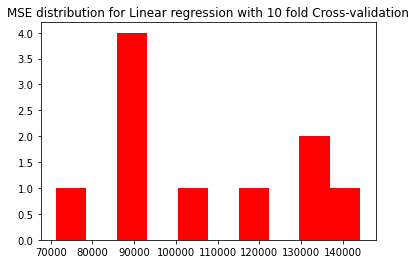

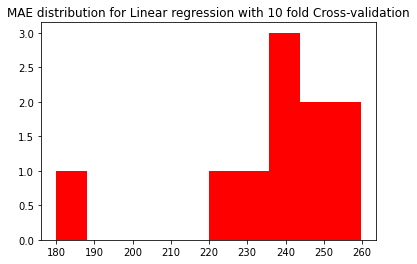

In [13]:

X_features=df_seg.iloc[:,2:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
y=np.array(y).reshape(-1,1)

kf = KFold(n_splits=10)
mse_a=[]
mae_a=[]
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     print(f'X:{x_test},y: {y_test}')
    

    lin_reg_model=LinearRegression()
    
    train_mean=np.mean(x_train,axis=0)
    train_std=np.std(x_train,axis=0)
    x_train_norm = (x_train - train_mean)/(train_std + 0.00001)
    lin_reg_model.fit(x_train_norm,y_train)


    x_test_norm = (x_test - train_mean)/(train_std + 0.00001)
    ypred=lin_reg_model.predict(x_test_norm)
#     print(f'predictions:{list(ypred)}')
#     print(f'y_test:{list(y_test)}')
    mse=mean_squared_error(y_test, ypred)
    mae=mean_absolute_error(y_test, ypred)
    mse_a.append(mse)
    mae_a.append(mae)
    r_square= r2_score(y_test, ypred)
#     print('mse',mse)
#     print('mae',mae)
    print('r_sq', r_square)

print(mse_a)  
plt.figure();plt.title('MSE distribution for Linear regression with 10 fold Cross-validation')
plt.hist(mse_a, density=False,color='r') 
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse}')
print(f'Std dev: {np.array(mse_a).std()}')

plt.figure();plt.title('MAE distribution for Linear regression with 10 fold Cross-validation')
plt.hist(mae_a, density=False,color='r')
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae}')
print(f'Std dev: {np.array(mae_a).std()}')




## SVR Linear regression CV with all features together

(236, 4)
[75517.96382611948, 74942.87626012861, 153476.23092890184, 130773.95625157068, 102717.9972677235, 84727.12046559186, 158345.63949602886, 151887.69138241262, 97173.29262756814, 107242.73362792155]
Mean MSE:113680.55021339671
Std dev: 30919.315403559467
[166.53651034710865, 208.4123390310135, 242.88566886316758, 236.94105381740937, 221.93870655843298, 208.3543423536039, 250.01455959351003, 263.63900523174334, 220.77221211048115, 230.2391848782839]
Mean MAE:224.97335827847547
Std dev: 25.702300557645856


C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

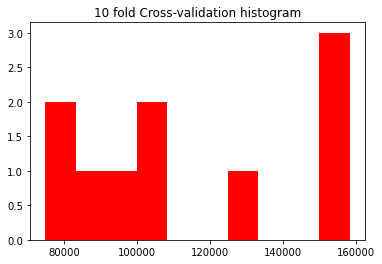

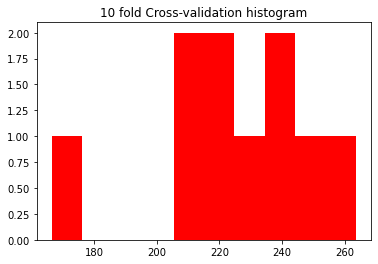

In [14]:
## SVR Linear with all features
X_features=df_seg.iloc[:,2:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
print(X.shape)
y=df_seg.Survival_days
y=np.array(y).reshape(-1,1)
# 

kf = KFold(n_splits=10)
mse_a=[]
mae_a=[]
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    SVR_model=SVR(kernel='linear', C=100)
    
    # # svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    train_mean=np.mean(x_train,axis=0)
    train_std=np.std(x_train,axis=0)
    x_train_norm = (x_train - train_mean)/(train_std + 0.00001)
    SVR_model.fit(x_train_norm,y_train)


    x_test_norm = (x_test - train_mean)/(train_std + 0.00001)
    ypred=SVR_model.predict(x_test_norm)
#     print(f'predictions:{ypred}')
#     print(f'y_test:{list(y_test)}')
    mse=mean_squared_error(y_test, ypred)
    mse_a.append(mse)
    mae=mean_absolute_error(y_test, ypred)
    mae_a.append(mae)
    r_square= r2_score(y_test, ypred)
#     print('mse',mse)
#     print('mae',mae)
#     print('r_sq', r_square)

print(mse_a)  
plt.figure();plt.title('10 fold Cross-validation histogram')
plt.hist(mse_a, density=False, color='r') 
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse}')
print(f'Std dev: {np.array(mse_a).std()}')


print(mae_a)  
plt.figure();plt.title('10 fold Cross-validation histogram')
plt.hist(mae_a, density=False, color='r') 
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae}')
print(f'Std dev: {np.array(mae_a).std()}')


## SVR with rbf kernel regression CV with all features together

(236, 4)
Mean MSE:120120.42077765297 Days^2
Std dev: 34646.40202396617 Days^2
Mean MAE:229.53212281392285 Days
Std dev: 26.03698484832848 Days


C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

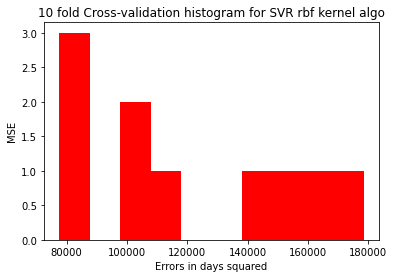

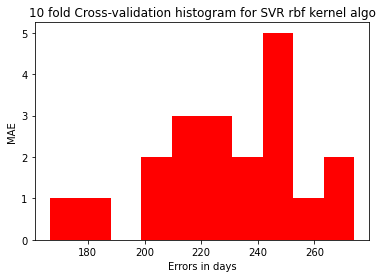

In [15]:

X_features=df_seg.iloc[:,2:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
# # X_norm= (X-np.mean(X,dim=1))/np.std(X,dim=1)
print(X.shape)
y=df_seg.Survival_days
y= np.array(y).reshape(-1,1)

kf = KFold(n_splits=10)
mse_a=[]
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.1, random_state=32, shuffle=True)
    SVR_model=SVR(kernel='rbf', C=100)
    # # svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    train_mean=np.mean(x_train,axis=0)
    train_std=np.std(x_train,axis=0)
    x_train_norm = (x_train - train_mean)/(train_std + 0.00001)
    SVR_model.fit(x_train_norm,y_train)


    x_test_norm = (x_test - train_mean)/(train_std + 0.00001)
    ypred=SVR_model.predict(x_test_norm)
#     print(f'predictions:{ypred}')
#     print(f'y_test:{list(y_test)}')
    mse=mean_squared_error(y_test, ypred)
    mae=mean_absolute_error(y_test, ypred)
    mse_a.append(mse)
    mae_a.append(mae)
#     print('mse',mse)
#     print('mae',mae)

# print(mse_a)  
plt.figure();plt.title('10 fold Cross-validation histogram for SVR rbf kernel algo')
plt.xlabel('Errors in days squared')
plt.ylabel('MSE')
plt.hist(mse_a, density=False, color='r') 
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse} Days^2')
print(f'Std dev: {np.array(mse_a).std()} Days^2')


plt.figure();plt.title('10 fold Cross-validation histogram for SVR rbf kernel algo')
plt.xlabel('Errors in days')
plt.ylabel('MAE')
plt.hist(mae_a, density=False, color='r') 
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae} Days')
print(f'Std dev: {np.array(mae_a).std()} Days')


## SVR with Poly kernel regression CV with all features together

(236, 4)
Mean MSE:123003.82519457354 Days^2
Std dev: 32988.36472513465 Days^2
Mean MAE:232.19714471834698 Days
Std dev: 28.90346767900969 Days


C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\hamsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

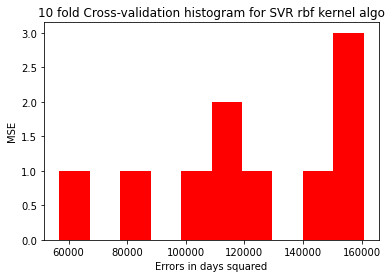

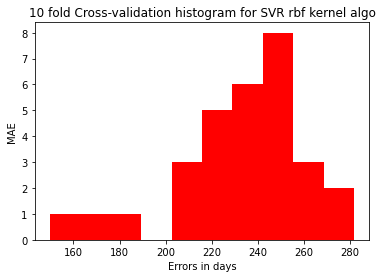

In [16]:

X_features=df_seg.iloc[:,2:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
# # X_norm= (X-np.mean(X,dim=1))/np.std(X,dim=1)
print(X.shape)
y=df_seg.Survival_days
y= np.array(y).reshape(-1,1)

kf = KFold(n_splits=10)
mse_a=[]
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # x_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.1, random_state=32, shuffle=True)
    SVR_model=SVR(kernel='poly', C=100, degree=3)
    # # svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    train_mean=np.mean(x_train,axis=0)
    train_std=np.std(x_train,axis=0)
    x_train_norm = (x_train - train_mean)/(train_std + 0.00001)
    SVR_model.fit(x_train_norm,y_train)


    x_test_norm = (x_test - train_mean)/(train_std + 0.00001)
    ypred=SVR_model.predict(x_test_norm)
#     print(f'predictions:{ypred}')
#     print(f'y_test:{list(y_test)}')
    mse=mean_squared_error(y_test, ypred)
    mae=mean_absolute_error(y_test, ypred)
    mse_a.append(mse)
    mae_a.append(mae)
#     print('mse',mse)
#     print('mae',mae)

# print(mse_a)  
plt.figure();plt.title('10 fold Cross-validation histogram for SVR rbf kernel algo')
plt.xlabel('Errors in days squared')
plt.ylabel('MSE')
plt.hist(mse_a, density=False, color='r') 
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse} Days^2')
print(f'Std dev: {np.array(mse_a).std()} Days^2')


plt.figure();plt.title('10 fold Cross-validation histogram for SVR rbf kernel algo')
plt.xlabel('Errors in days')
plt.ylabel('MAE')
plt.hist(mae_a, density=False, color='r') 
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae} Days')
print(f'Std dev: {np.array(mae_a).std()} Days')


## Random forest regression with width information as features

Mean MSE:136453.6311965 Days^2
Std dev: 46498.92822117456 Days^2
Mean MAE:277.54756666666657 Days
Std dev: 45.43606491427705 Days


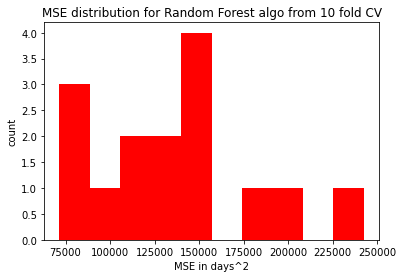

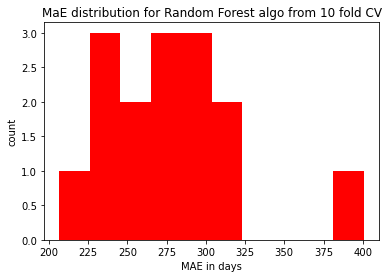

In [17]:

# age, max widths in label1, label2 and label4
X_features=df_seg.iloc[:,3:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
y=np.array(y)


kf = KFold(n_splits=15)
mse_a=[]
mae_a=[]
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor(n_estimators = 100)
    # Train the model on training data
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    errors = mean_squared_error(predictions, y_test)
    mae_errors = mean_absolute_error(predictions, y_test)
#     print(f'predictions:{predictions}')
#     print(f'y_test:{list(y_test)}')
#     print('mse',errors)
    mse_a.append(errors)
#     print('mae',mae_errors)
    mae_a.append(mae_errors)
    
# print(mse_a)  
plt.figure();plt.title('MSE distribution for Random Forest algo from 10 fold CV')
plt.hist(mse_a, density=False, color='r');plt.xlabel('MSE in days^2');plt.ylabel('count')
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse} Days^2')
print(f'Std dev: {np.array(mse_a).std()} Days^2')


plt.figure();plt.title('MaE distribution for Random Forest algo from 10 fold CV')
plt.hist(mae_a, density=False, color='r');plt.xlabel('MAE in days');plt.ylabel('count')
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae} Days')
print(f'Std dev: {np.array(mae_a).std()} Days')

## Random forest regression with all features 

C:\Users\hamsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\hamsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\hamsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\hamsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\hamsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vec

Mean MSE:126970.79974898552
Std dev: 26353.49059481846
Mean MAE:263.51903623188406
Std dev: 24.823692706152123


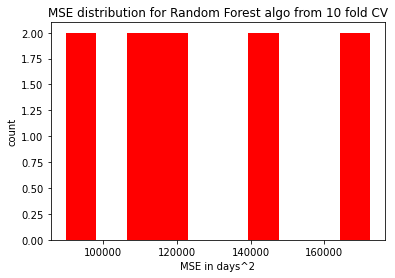

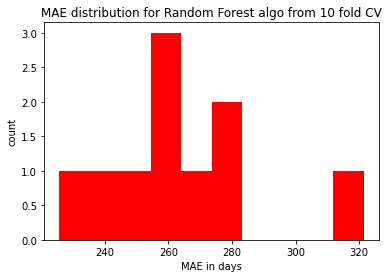

In [18]:

# age, max widths in label1, label2 and label4
X_features=df_seg.iloc[:,2:6].values
y=df_seg.iloc[:,1]

X = np.array(X_features)
y=np.array(y).reshape(-1,1)


kf = KFold(n_splits=10)
mse_a=[]
mae_a=[]
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor(n_estimators = 100)
    # Train the model on training data
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    errors = mean_squared_error(predictions, y_test)
    mae_errors = mean_absolute_error(predictions, y_test)
#     print(f'predictions:{predictions}')
#     print(f'y_test:{list(y_test)}')
#     print('mse',errors)
    mse_a.append(errors)
#     print('mae',mae_errors)
    mae_a.append(mae_errors)
    
# print(mse_a)  
plt.figure();plt.title('MSE distribution for Random Forest algo from 10 fold CV')
plt.hist(mse_a, density=False, color='r');plt.xlabel('MSE in days^2');plt.ylabel('count')
mean_mse=np.array(mse_a).mean()
print(f'Mean MSE:{mean_mse}')
print(f'Std dev: {np.array(mse_a).std()}')

plt.figure();plt.title('MAE distribution for Random Forest algo from 10 fold CV')
plt.hist(mae_a, density=False, color='r');plt.xlabel('MAE in days');plt.ylabel('count')
mean_mae=np.array(mae_a).mean()
print(f'Mean MAE:{mean_mae}')
print(f'Std dev: {np.array(mae_a).std()}')

Importance of features used in the random forest algorithm


In [19]:
importances = list(rf.feature_importances_)
print(importances)
feature_list = list(df_seg.columns)[2:]
print(feature_list)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

[0.4201952396204069, 0.2113508204077924, 0.1493144956029927, 0.21913944436880806]
['Age', 'label1', 'label2', 'label4']
Variable: Age                  Importance: 0.42
Variable: label4               Importance: 0.22
Variable: label1               Importance: 0.21
Variable: label2               Importance: 0.15


https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

## How to find the best kernel or model? hyperparameter tuning. But it is a task in itself. Parked for now.
